# Copula-based Risk Aggregation with Trapped Ion Quantum Computers

## Qiskit implementation by Jon Pilarte

[Read the related paper here](https://www.nature.com/articles/s41598-023-44151-1)


In [1]:
%%capture
!conda activate qiskit #Activate the qiskit environment with qiskit==0.46.2 and qiskit-machine-learning==0.5.0
!pip install pandas numpy scipy yfinance statsmodels matplotlib copulas

In [2]:
%%capture
!pip install qiskit==0.46.2 qiskit-machine-learning==0.5.0 qiskit-aer pylatexenc

# Classical Approach

In [122]:
import numpy as np
import pandas as pd
import yfinance as yf

# Define the stocks to be used
stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

# Fetch the data from Yahoo Finance
data = yf.download(stocks, start='2000-01-01', end='2023-01-01')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()
returns

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2004-08-20,0.002930,0.022780,0.079430,0.002949
2004-08-23,0.009091,-0.001519,0.010064,0.004426
2004-08-24,0.027993,-0.010139,-0.041408,0.000000
2004-08-25,0.034429,0.032010,0.010775,0.011380
2004-08-26,0.048714,-0.002730,0.018019,-0.003993
...,...,...,...,...
2022-12-23,-0.002798,0.017425,0.017562,0.002267
2022-12-27,-0.013878,-0.025924,-0.020933,-0.007414
2022-12-28,-0.030685,-0.014692,-0.016718,-0.010255


In [123]:
# Calculate statistical properties
properties = returns.describe().T
properties['skew'] = returns.skew()
properties['kurtosis'] = returns.kurtosis()

# Display statistical properties
print("Statistical Properties:")
print(properties)

Statistical Properties:
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
AAPL    4624.0  0.001438  0.021002 -0.179195 -0.008530  0.001091  0.012046   
AMZN    4624.0  0.001110  0.024353 -0.218220 -0.009988  0.000576  0.012235   
GOOG    4624.0  0.000958  0.019373 -0.116091 -0.007725  0.000693  0.010025   
MSFT    4624.0  0.000719  0.017239 -0.147390 -0.007138  0.000392  0.008726   

             max      skew   kurtosis  
Ticker                                 
AAPL    0.139050  0.052578   5.300518  
AMZN    0.269497  0.888905  15.129384  
GOOG    0.199915  0.692983   9.573968  
MSFT    0.186047  0.256073  10.354862  


In [124]:
from scipy.stats import t, norm
# Fit t-distributions to each stock's returns
marginals = {}
for stock in returns.columns:
    params = t.fit(returns[stock])
    marginals[stock] = params

# Transform original data to uniform distribution using fitted marginals
uniform_data = pd.DataFrame()
for stock in returns.columns:
    params = marginals[stock]
    uniform_data[stock] = t.cdf(returns[stock], *params)

# Display the transformed uniform data
print(uniform_data.head())

       AAPL      AMZN      GOOG      MSFT
0  0.540888  0.886435  0.996127  0.580978
1  0.690869  0.444557  0.752858  0.629902
2  0.927290  0.255704  0.019528  0.478279
3  0.954318  0.939438  0.767785  0.809681
4  0.981545  0.414777  0.877853  0.344685


In [125]:
from copulas.multivariate import GaussianMultivariate
# Fit the copula model
copula = GaussianMultivariate()
copula.fit(uniform_data)

# Generate synthetic data
synthetic_data = copula.sample(5000)

# Display synthetic data
synthetic_data_df = pd.DataFrame(synthetic_data, columns=stocks)
print("Synthetic Data (Classical Approach):")
print(synthetic_data_df.head())

Synthetic Data (Classical Approach):
       AAPL      MSFT      GOOG      AMZN
0  0.157519  0.015097  0.031880  0.003723
1  0.447345  0.020721  0.462077  0.238374
2  0.341512  0.109684  0.206665  0.136849
3  0.510126  0.455354  0.671989  0.514069
4  0.676823  0.733633  0.636972  0.952347


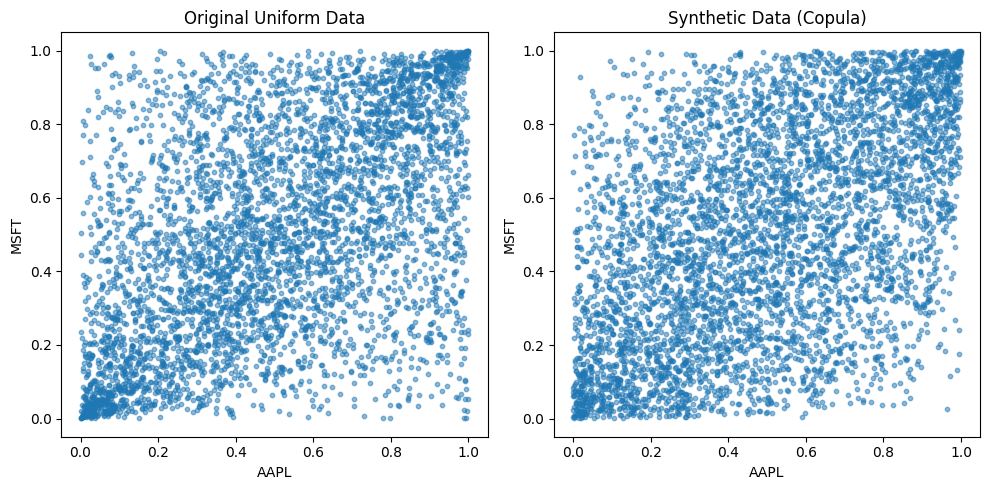

In [126]:
import matplotlib.pyplot as plt

# Plot original uniform data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(uniform_data['AAPL'], uniform_data['MSFT'], alpha=0.5, s=10)  # Adjust s parameter for smaller points
plt.xlabel('AAPL')
plt.ylabel('MSFT')
plt.title('Original Uniform Data')

# Plot synthetic data
plt.subplot(1, 2, 2)
plt.scatter(synthetic_data_df['AAPL'], synthetic_data_df['MSFT'], alpha=0.5, s=10)  # Adjust s parameter for smaller points
plt.xlabel('AAPL')
plt.ylabel('MSFT')
plt.title('Synthetic Data (Copula)')

plt.tight_layout()
plt.show()

# Quantum Formulation

c:\Users\Jon\miniconda3\envs\qiskit\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


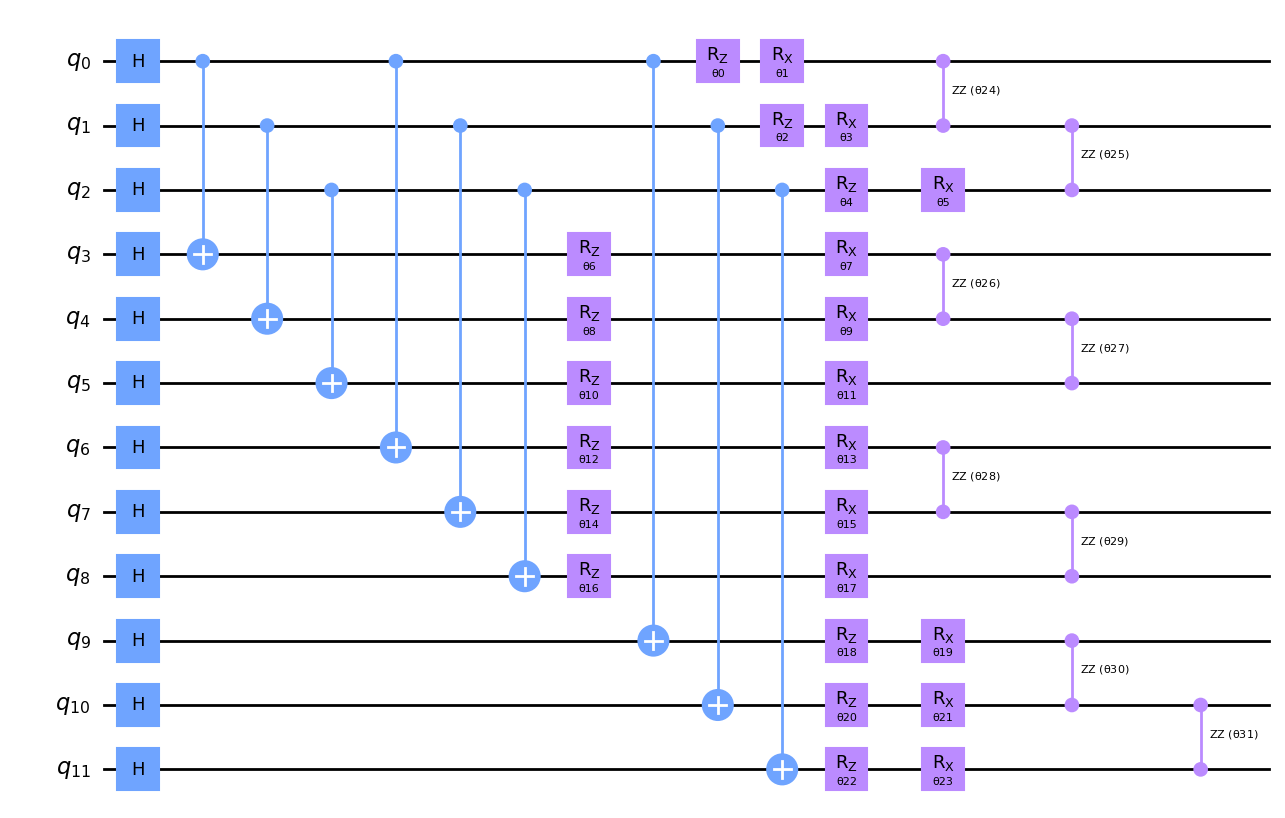

In [127]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.circuit import Parameter
import numpy as np

# Number of variables (qubits) and precision (number of bits)
n = 4
m = 3
# 1 layer, each with 8*n parameters, in total 32 for this example

# Initialize quantum circuit
qc = QuantumCircuit(n * m)

# Add Hadamard gates to all qubits
for qubit in range(n * m):
    qc.h(qubit)

# Add CNOT gates based on the specified pattern
for qubit in range(n * m-m):
    qc.cx((qubit % m), (qubit+m))

# Define parameters for the circuit
num_params = 8*n 
params = [Parameter(f'θ{i}') for i in range(num_params)]

# Layer 1: Apply RZ, RX gates with parameters
for qubit in range(n * m):
    qc.rz(params[2 * qubit], qubit)
    qc.rx(params[2 * qubit + 1], qubit)

#RZZ gates for entanglement with its parameters 
for qubit in range(n): 
    qc.rzz(params[(2*n*m) + 2*qubit], 3*qubit, 3*qubit + 1)
    qc.rzz(params[(2*n*m) + 2*qubit+1], 3*qubit + 1, 3*qubit + 2)

# Show the circuit
qc.draw('mpl')

In [128]:
def copula_to_binary(copula_samples, n, m):
    # Convert data samples to binary-valued samples
    binary_samples = np.zeros((copula_samples.shape[0], n, m), dtype=int)

    for i in range(copula_samples.shape[0]):
        for j in range(n):
            # Convert each di to bi
            di = copula_samples[i, j]
            remaining_value = di
            for k in range(m):
                threshold = 1 / (2 ** (k + 1))
                if remaining_value >= threshold:
                    binary_samples[i, j, k] = 1
                    remaining_value -= threshold
                    #print(k, threshold, remaining_value)
                else:
                    binary_samples[i, j, k] = 0

    # Concatenate binary strings of all variables into a single binary string
    combined_binary_samples = np.zeros((copula_samples.shape[0], n * m), dtype=int)

    for i in range(copula_samples.shape[0]):
        combined_binary_samples[i] = binary_samples[i].flatten()

    return combined_binary_samples


# Take data from the classical approach
pseudo_samples = uniform_data.to_numpy()

# Display the first 5 combined binary samples
combined_binary_samples=copula_to_binary(pseudo_samples,4,3)
print(uniform_data[:5])
print(combined_binary_samples[:5])

       AAPL      AMZN      GOOG      MSFT
0  0.540888  0.886435  0.996127  0.580978
1  0.690869  0.444557  0.752858  0.629902
2  0.927290  0.255704  0.019528  0.478279
3  0.954318  0.939438  0.767785  0.809681
4  0.981545  0.414777  0.877853  0.344685
[[1 0 0 1 1 1 1 1 1 1 0 0]
 [1 0 1 0 1 1 1 1 0 1 0 1]
 [1 1 1 0 1 0 0 0 0 0 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 0]
 [1 1 1 0 1 1 1 1 1 0 1 0]]


In [129]:
def binary_to_copula(combined_binary_samples, n, m):
    # Convert combined binary strings back to normal data samples
    converted_pseudo_samples = np.zeros((combined_binary_samples.shape[0], n))

    for i in range(combined_binary_samples.shape[0]):
        for j in range(n):
            binary_string = combined_binary_samples[i, j * m:(j + 1) * m]
            dj = sum([binary_string[k] * (2 ** (m - 1 - k)) for k in range(m)]) / (2 ** m)
            delta = np.random.rand() / (2 ** m)
            converted_pseudo_samples[i, j] = dj + delta #Adding noise 

    return converted_pseudo_samples

# Display the first 5 converted data samples
print(combined_binary_samples[:5])
print(binary_to_copula(combined_binary_samples, 4, 3)[:5])

[[1 0 0 1 1 1 1 1 1 1 0 0]
 [1 0 1 0 1 1 1 1 0 1 0 1]
 [1 1 1 0 1 0 0 0 0 0 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 0]
 [1 1 1 0 1 1 1 1 1 0 1 0]]
[[0.50353678 0.97013087 0.9276563  0.62455307]
 [0.73748645 0.40945574 0.85248963 0.72916874]
 [0.95728318 0.32668961 0.09000893 0.45774783]
 [0.87759005 0.88767444 0.77064234 0.7870646 ]
 [0.91986521 0.47540425 0.96111325 0.35231228]]


In [130]:
# Define the KL divergence loss function for dictionary-based probability distributions
def kl_divergence(p, q, epsilon=1e-8):
    kl_div = 0
    for key in p:
        p_val = p[key]
        q_val = q.get(key, epsilon)  # Use epsilon for missing keys in q to avoid singularity
        kl_div += p_val * np.log(p_val / q_val)
    return kl_div

In [131]:
# Obtain probability distribution out of the binary strings  
from collections import Counter

def get_binary_distribution_prob(combined_binary_samples):
    # Convert binary samples to tuple format for counting
    binary_tuples = [tuple(row.tolist()) for row in combined_binary_samples]

    # Count the frequency of each unique binary string
    binary_distribution = Counter(binary_tuples)

    # Convert to a probability distribution
    total_samples = len(combined_binary_samples)
    binary_distribution_prob = {k: v / total_samples for k, v in binary_distribution.items()}

    return binary_distribution_prob

binary_distribution_prob=get_binary_distribution_prob(copula_to_binary(uniform_data.to_numpy(),4,3))

# Display only 5 elements of the probability distribution
for i, (binary_string, probability) in enumerate(binary_distribution_prob.items()):
    if i < 5:
        print(f"Binary String: {binary_string}, Probability: {probability:.5f}")
    else:
        break

Binary String: (1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0), Probability: 0.00065
Binary String: (1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1), Probability: 0.00087
Binary String: (1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1), Probability: 0.00022
Binary String: (1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0), Probability: 0.00260
Binary String: (1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0), Probability: 0.00022


In [132]:
from itertools import product

def create_uniform_distribution(n):
    binary_strings = list(product([0, 1], repeat=n))
    total_strings = len(binary_strings)
    uniform_prob = 1 / total_strings
    
    uniform_distribution = {binary_string: uniform_prob for binary_string in binary_strings}
    
    return uniform_distribution

# Example usage for 12 digit binary strings
uniform_distribution = create_uniform_distribution(n*m)

#len(uniform_distribution)=4096 covering all the possible binary strings of 12 digits

# Display only 5 elements of the uniform distribution
for i, (binary_string, probability) in enumerate(uniform_distribution.items()):
    if i < 5:
        print(f"Binary String: {binary_string}, Probability: {probability:.4f}")
    else:
        break

Binary String: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), Probability: 0.0002
Binary String: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1), Probability: 0.0002
Binary String: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0), Probability: 0.0002
Binary String: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1), Probability: 0.0002
Binary String: (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0), Probability: 0.0002


In [133]:
# Define the number of rows for training and target distribution (80% of the total 4624 samples)
# It starts from a uniform distribution as train_data
# During training, KL-divergence between both distributions is minimized in each iteration
# We use the distribution of binary strings converted from the training set as the target_distribution to train the quantum model

num_rows = int(0.8 * 4624)
train_data = uniform_distribution
target_distribution = get_binary_distribution_prob(copula_to_binary(uniform_data.to_numpy(),4,3)[:num_rows])

kl_divergence(train_data, target_distribution) #Initial KL divergence

np.float64(5.239167155420065)

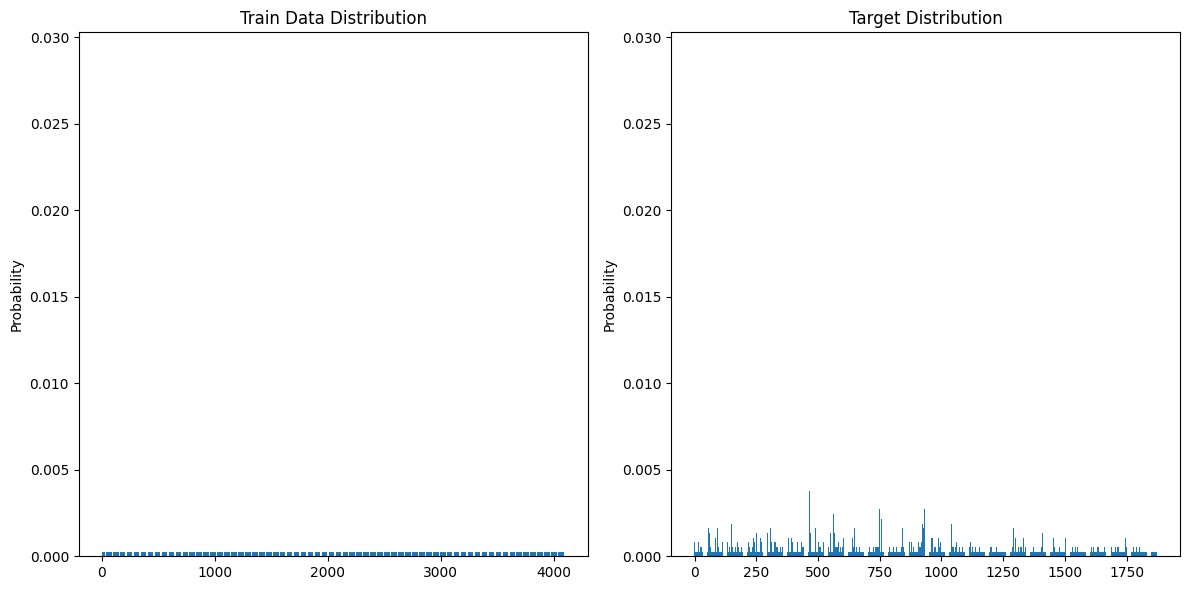

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Function to plot histograms of two distributions side by side
def plot_histograms(train_data, target_distribution):
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot histogram for train_data
    train_data_tuples = [tuple(row) for row in train_data]
    train_data_counts = Counter(train_data_tuples)
    train_data_values = list(train_data_counts.values())
    
    # Normalize train data to probabilities
    total_train = sum(train_data_values)
    train_data_prob = [value / total_train for value in train_data_values]

    axs[0].bar(range(len(train_data_values)), train_data_prob)
    axs[0].set_title('Train Data Distribution')
    axs[0].set_ylabel('Probability')
    
    # Plot histogram for target_distribution
    target_values = list(target_distribution.values())

    axs[1].bar(range(len(target_values)), target_values)
    axs[1].set_title('Target Distribution')
    axs[1].set_ylabel('Probability')
    
    # Set the same y-axis limits for both plots
    max_prob = max(max(train_data_prob), max(target_values))
    axs[0].set_ylim(0, max_prob)
    axs[1].set_ylim(0, max_prob)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot histograms
plot_histograms(train_data, target_distribution)

In [135]:
def array_to_probability_dict(prob_array, n, m):
    # Generate all possible binary strings of length n*m
    binary_strings = [format(i, f'0{n*m}b') for i in range(2**(n*m))]
    
    # Create the dictionary mapping binary tuples to their probabilities
    probability_dict = {tuple(map(int, list(binary_strings[i]))): prob_array[i] for i in range(2**(n*m))}
    
    return probability_dict

C:\Users\Jon\AppData\Local\Temp\ipykernel_45292\3955746207.py:11: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend)
No interpret function given, output_shape will be automatically determined as 2^num_qubits.


Initial KL divergence: 5.619843258729184
Optimized KL divergence: 3.675110809893672


c:\Users\Jon\miniconda3\envs\qiskit\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


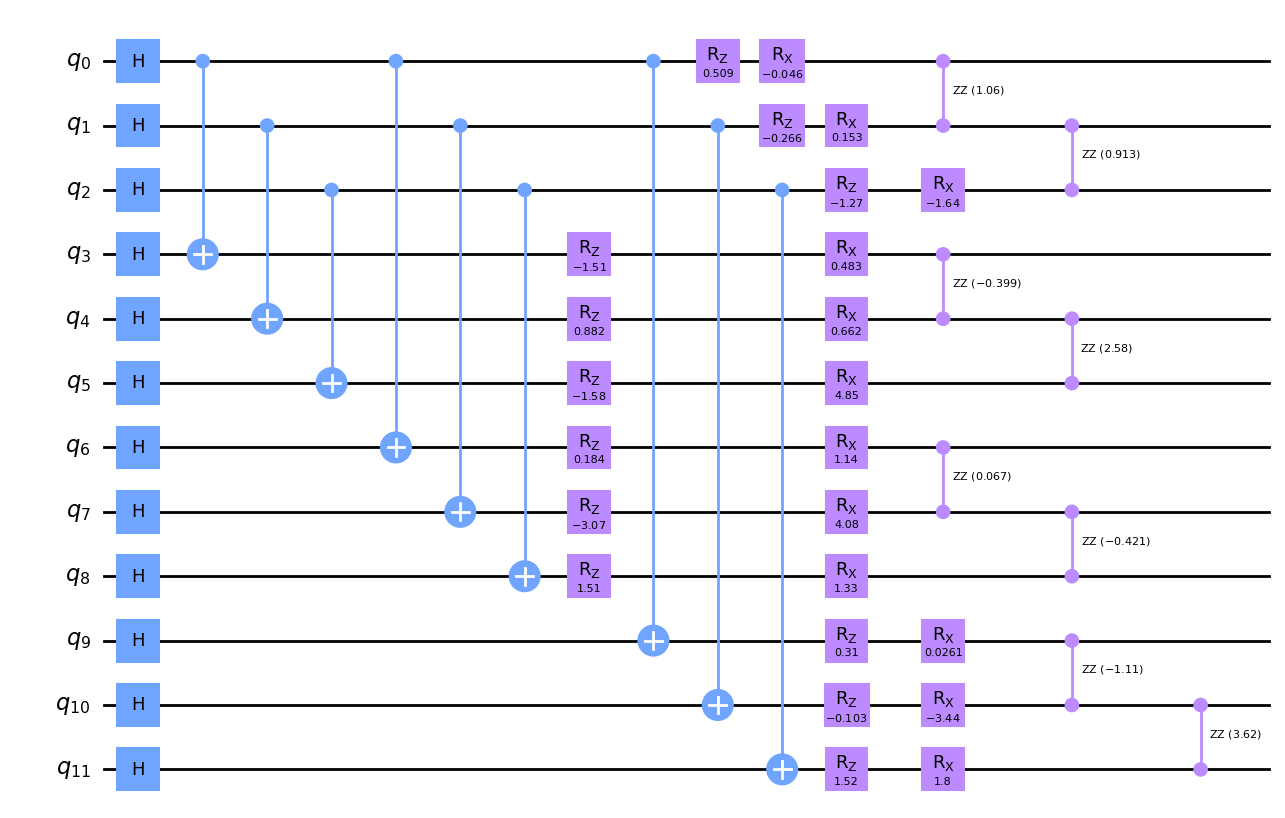

In [136]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import SPSA
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler
from qiskit.utils import QuantumInstance
import numpy as np

# Initialize backend and quantum instance
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend)
sampler = Sampler()

# Define the SamplerQNN
qnn = SamplerQNN(circuit=qc, weight_params=qc.parameters, output_shape=2**(n*m), sampler=sampler)
# qnn.circuit.draw('mpl')

# Initialize SPSA optimizer for 150 iterations
spsa = SPSA(maxiter=150) #Add learning_rate and perturbation parameters to increase stability

# Define the cost function for SPSA optimizer
def cost_function(weights):
    train_distribution = qnn.forward(input_data=None, weights=[weights])
    train_distribution=array_to_probability_dict(train_distribution[0], n, m)
    return kl_divergence(train_distribution, target_distribution)

# Initial parameters for optimization
initial_params = np.random.rand(qnn.num_weights)

# Optimization loop using minimize SPSA
result = spsa.minimize(
    fun=cost_function,
    x0=initial_params)

optimal_params = result.x
optimal_value = result.fun

# Apply optimal parameters to the quantum circuit
parameter_binds = {param: value for param, value in zip(qnn.weight_params, optimal_params)}
qc.assign_parameters(parameter_binds, inplace=True)

# Calculate and print the initial and optimized KL divergence
initial_kl_divergence = cost_function(initial_params)
optimized_kl_divergence = cost_function(optimal_params)

print(f"Initial KL divergence: {initial_kl_divergence}")
print(f"Optimized KL divergence: {optimized_kl_divergence}")
qc.draw('mpl')